In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


# 1. Auto MPG数据集
- 1.1. 获取数据
- 1.2. 清理数据
- 1.3. 将数据分为训练集和测试集
- 1.4. 检查数据
- 1.5. 从标签中分割特征
- 1.6. 标准化数据

In [3]:
#-------------- 1.1. 获取数据

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()

print(f"dataset_path:{dataset_path}")
dataset.tail()

32768/30286 [================================] - 2s 64us/step
dataset_path:/Users/zhouwencheng/.keras/datasets/auto-mpg.data


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
#------------------- 1.2. 清理数据
print(f"dataset.isna().sum():\n{dataset.isna().sum()}")

# 这是一个入门教程，所以我们就简单地删除这些行。
dataset = dataset.dropna()

# “Origin”这一列实际上是分类，而不是数字。 所以把它转换为独热编码：
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

dataset.isna().sum():
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [7]:
#--------------------------- 1.3. 将数据分为训练集和测试集

# 现在将数据集拆分为训练集和测试集，我们将在模型的最终评估中使用测试集。

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

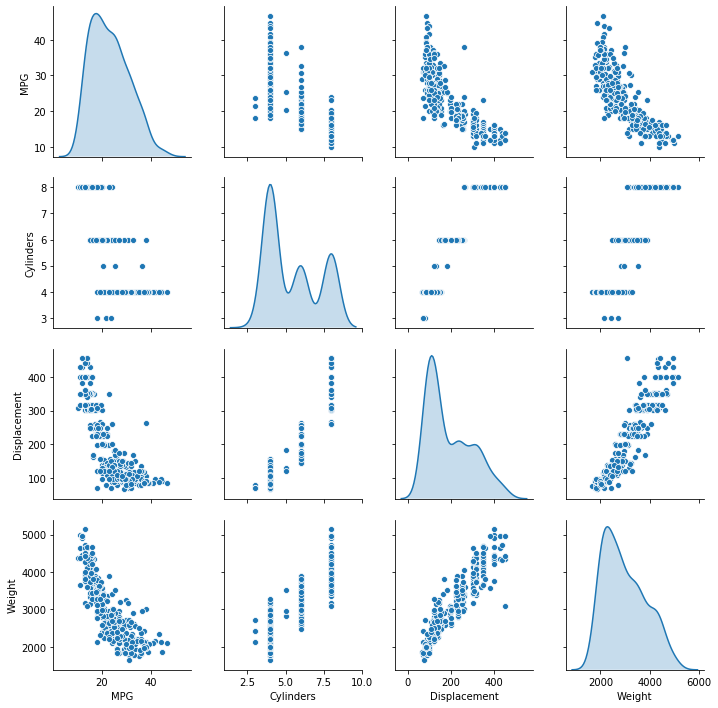

In [8]:
#--------------------------- 1.4. 检查数据

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [9]:
# 另外查看整体统计数据：
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [10]:
#------------------------- 1.5. 从标签中分割特征

# 将目标值或“标签”与特征分开，此标签是您训练的模型进行预测的值：

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [11]:
#----------------------- 1.6. 标准化数据

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# 2. 模型
- 2.1. 构建模型
- 2.2. 检查模型
- 2.3. 训练模型
- 2.4. 预测

In [13]:
#-------------------- 2.1. 构建模型

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ]) 
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

In [14]:
#------------------------ 2.2. 检查模型
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 现在试试这个模型。从训练数据中取出一批10个样本数据并在调用model.predict函数。

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1934469 ],
       [-0.2955739 ],
       [ 0.02485348],
       [-0.76419675],
       [ 0.32668972],
       [-0.16618298],
       [ 0.24473149],
       [ 0.40189758],
       [-0.01663706],
       [ 0.42804322]], dtype=float32)

In [16]:
#--------------------------- 2.3. 训练模型

# 训练模型1000个周期，并在history对象中记录训练和验证准确性：
# 通过为每个完成的周期打印单个点来显示训练进度 
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

print("OK")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [17]:
# 使用存储在history对象中的统计数据可视化模型的训练进度。300

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.539384,1.020243,2.539384,8.308102,2.192406,8.308102,995
996,2.314656,0.949946,2.314656,8.520619,2.235036,8.520620,996
997,2.453593,0.981000,2.453593,8.533504,2.281582,8.533504,997
998,2.523247,0.993323,2.523247,8.335670,2.179053,8.335670,998
999,2.413312,1.014716,2.413312,10.474121,2.559835,10.474121,999


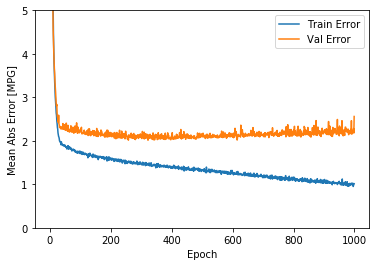

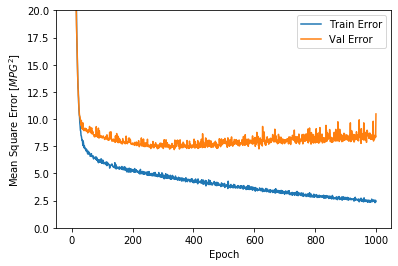

In [18]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


.........................................

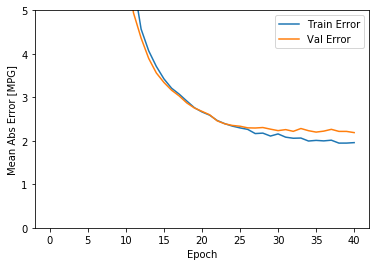

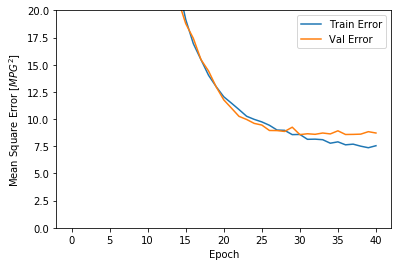

In [19]:
model = build_model()

# “patience”参数是检查改进的周期量 
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [20]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.99 MPG


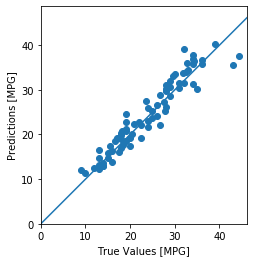

In [21]:
#---------------------- 2.4. 预测

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

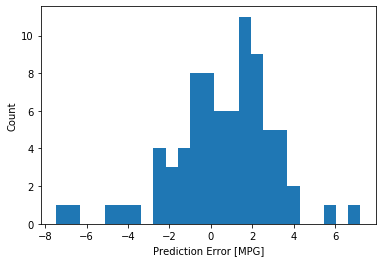

In [22]:
# 看起来我们的模型预测得相当好，我们来看看错误分布：

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")